## Dataset: Kaggle NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
- https://www.kaggle.com/c/nlp-getting-started/overview

Semi supervised Logistic Regression and K-Nearest Neighbors binary classification task

## 1.) Importing libraries

In [ ]:
!pip -qq install tweet-preprocessor

In [ ]:
import os
import numpy as np
import pandas as pd
from time import time
import preprocessor as p
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, silhouette_samples, classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

sns.set_theme(style = "whitegrid", palette = "colorblind")
plt.rcParams["image.cmap"] = "Paired"

## 2.) Data Preprocessing

In [ ]:
path = ''

train_data_path = os.path.join(path, "data", "train.csv")

raw_data = pd.read_csv(train_data_path)
raw_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### 2.1. Data Cleaning

In [ ]:
# Text cleaning - Removing URLs, mentions, etc using tweet-preprocessor package
def tweet_clean(tweet, replace_amper = False):
  """
  Clean tweet with tweet-preprocessor p.clean().
  """
  # Remove user mentions, symbols and unwanted characters
  p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED,
                p.OPT.EMOJI, p.OPT.SMILEY)
  tweet = p.clean(tweet)
  
  # Replace amper
  if replace_amper:
    tweet = tweet.replace('&amp;', 'and')
    tweet = tweet.replace('&AMP;', 'and')

  return tweet

In [ ]:
# Cleaned tweets
raw_data['cleaned_text'] = raw_data['text'].apply(tweet_clean, replace_amper = True)
for tweet, cleaned_tweet in zip(raw_data['text'].tail(),
                                raw_data['cleaned_text'].tail()):
  print(f'Original tweet: {tweet}')
  print(f'Cleaned tweet: {cleaned_tweet}\n-')

Original tweet: Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5
Cleaned tweet: Two giant cranes holding a bridge collapse into nearby homes
-
Original tweet: @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.
Cleaned tweet: The out of control wild fires in California even in the Northern part of the state. Very troubling.
-
Original tweet: M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ
Cleaned tweet: M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
-
Original tweet: Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
Cleaned tweet: Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
-
Original tweet: The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d
C

### 2.2. Training and Hold-out validation sets

In [ ]:
# Training and hold-out validation sets

# 80/20 training/validation split
train_size = int(0.8 * raw_data.shape[0])

train_index = [x for x in range(0, train_size)]
val_index = [x for x in range(train_size, raw_data.shape[0])]

X_train = raw_data.loc[train_index, 'cleaned_text']
y_train = raw_data.loc[train_index, 'target']

X_val = raw_data.loc[val_index, 'cleaned_text']
y_val = raw_data.loc[val_index, 'target']

print(f"Training set shape: {X_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation label shape: {y_val.shape}")

Training set shape: (6090,)
Training label shape: (6090,)
Validation set shape: (1523,)
Validation label shape: (1523,)


In [ ]:
# Training and validation maximum length sequences
print("Training set maximum length:", max([len(row.split()) for row in X_train]))
print("Validation set maximum length:", max([len(row.split()) for row in X_val]))

Training set maximum length: 31
Validation set maximum length: 30


### 2.3. TF-IDF Vectorization
Term Frequence, Inverse Document Frequence

In [ ]:
# TF-IDF Vectorization
max_features = None

vectorizer = TfidfVectorizer(max_features = max_features)

# Fitting vectorizer to training set vocabulary
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transforming the validation set
X_val_tfidf = vectorizer.transform(X_val)

print(f"TF-IDF normalized training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF normalized validation set shape: {X_val_tfidf.shape}")

TF-IDF normalized training set shape: (6090, 13053)
TF-IDF normalized validation set shape: (1523, 13053)


### 2.4. LSA and Optimal Hard Thresholding
- Latent Semantic Analysis with SVD (Singular Value Decomposition) for dimensionality reduction.
- Optimal Hard Thresholding (Gavish and Donoho, 2014)
- Normalization of samples to unit L2-norm.

> Support documentation:
- [Scikit-learn documentation: Clustering text documents using k-means](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)
- [Scikit-learn documentation: Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)
- [Scikit-learn documentation: Truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- [The Optimal Hard Threshold for Singular Values is 4/sqrt(3)](https://arxiv.org/abs/1305.5870)
- [Optimal Singular Value Hard Threshold python implementation](http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/)

In [ ]:
# Singular Value Decomposition with Numpy SVD
U, S, VT = np.linalg.svd(X_train_tfidf.toarray(), full_matrices=0)

# Optimal Hard Thresholding (Gavish and Donoho, 2014)
def omega_approx(X):
    """
    Return an approximate omega value for given matrix X. Equation (5) from
    Gavish and Donoho, 2014.
    """
    beta = min(X.shape) / max(X.shape)
    omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return omega

# Defining singular value hard threshold
def svht(X, sv = None):
    """
    Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values.
    """
    sv = np.squeeze(sv)
    if sv.ndim != 1:
        raise ValueError('vector of singular values must be 1-dimensional')
    return np.median(sv) * omega_approx(X)

cutoff = svht(X_train_tfidf.toarray(), sv = S) # Hard threshold
r_opt = np.max(np.where(S > cutoff)) # Keep modes w/ sig > cutoff 

print(f"Optimum number of eigen values: {r_opt}")

Optimum number of eigen values: 652


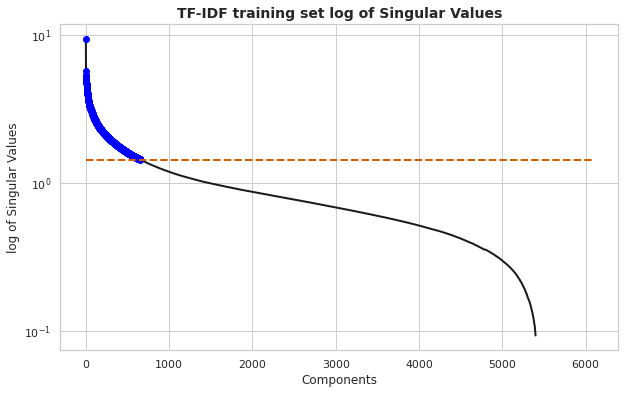

In [ ]:
# Plot TF-IDF vectorized dataset singular values
N = X_train_tfidf.shape[0]

plt.figure(figsize = (10, 6))
plt.semilogy(S[:5400], '-', color = 'k', LineWidth = 2) # Narrowing the visualization to the first relevant components
plt.semilogy(np.diag(S[:(r_opt + 1)]), 'o', color = 'blue', LineWidth = 2)
plt.plot(np.array([0, S.shape[0]]),np.array([cutoff, cutoff]), '--', color='r', LineWidth = 2)
plt.title("TF-IDF training set log of Singular Values", size = 14, fontweight = "bold")
plt.xlabel("Components")
plt.ylabel("log of Singular Values")
plt.show()

In [ ]:
# Singular Value Decomposition to reduce dimensionality truncated at optimum hard threshold
svd = TruncatedSVD(n_components = r_opt, random_state = 123)

# Standard normalization for spherical K-Means clustering
normalizer = Normalizer(copy = True)

# Latent Semantic Analysis dimensionality reduction pipeline
lsa = make_pipeline(svd, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_val_lsa = lsa.transform(X_val_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.2f}%")

print(f"LSA training set shape: {X_train_lsa.shape}")
print(f"LSA validation set shape: {X_val_lsa.shape}")

Explained variance of the SVD step: 53.75%
LSA training set shape: (6090, 652)
LSA validation set shape: (1523, 652)


## 3.) Metrics and evaluation routine
Models:
- Logistic Regression classifier
- K-Nearest Neighbors vote classifier

Metrics:
- Classification accuracy
- F-1 Score

In [ ]:
# Defining evaluate function
def evaluate(X_train, y_train, X_val, classif_report = True):
  '''
  Plot classification report for given training set using Logistic Regression
  and K-Nearest Neighbors classifiers.
  '''
  log_r = LogisticRegression()
  log_r.fit(X_train, y_train)
  y_pred_log_r = log_r.predict(X_val)

  knn_c = KNeighborsClassifier()
  knn_c.fit(X_train, y_train)
  y_pred_knn_c = knn_c.predict(X_val)

  if classif_report:
      print('Logistic Regression classification report: \n',
            classification_report(y_val, y_pred_log_r, digits = 3),
            '\n=====================================================\n')

      print('K-Nearest Neighbors vote classification report: \n',
            classification_report(y_val, y_pred_knn_c, digits = 3))
  
  log_r_f1 = f1_score(y_val, y_pred_log_r)
  log_r_acc = accuracy_score(y_val, y_pred_log_r)

  knn_c_f1 = f1_score(y_val, y_pred_knn_c)
  knn_c_acc = accuracy_score(y_val, y_pred_knn_c)

  return log_r_f1, log_r_acc, knn_c_f1, knn_c_acc

### 3.1. Performance on fully trained model

In [ ]:
# Evaluating performance using the complete training set
evaluate(X_train_tfidf, y_train, X_val_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.766     0.875     0.817       814
           1      0.828     0.693     0.754       709

    accuracy                          0.790      1523
   macro avg      0.797     0.784     0.785      1523
weighted avg      0.795     0.790     0.788      1523
 

K-Nearest Neighbors vote classification report: 
               precision    recall  f1-score   support

           0      0.713     0.808     0.758       814
           1      0.740     0.626     0.678       709

    accuracy                          0.724      1523
   macro avg      0.726     0.717     0.718      1523
weighted avg      0.726     0.724     0.721      1523



(0.7542242703533026,
 0.7898883782009193,
 0.6783804430863254,
 0.7235718975705844)

In [ ]:
# Evaluating performance using LSA reduced dimension training set
evaluate(X_train_lsa, y_train, X_val_lsa)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.776     0.812     0.794       814
           1      0.772     0.731     0.751       709

    accuracy                          0.774      1523
   macro avg      0.774     0.771     0.772      1523
weighted avg      0.774     0.774     0.774      1523
 

K-Nearest Neighbors vote classification report: 
               precision    recall  f1-score   support

           0      0.699     0.800     0.746       814
           1      0.725     0.605     0.659       709

    accuracy                          0.709      1523
   macro avg      0.712     0.702     0.703      1523
weighted avg      0.711     0.709     0.706      1523



(0.7507246376811595,
 0.7741300065659882,
 0.6594926979246734,
 0.7091267235718975)

### 3.2. Performance on naively reduced model

In [ ]:
# Evaluating performance with a reduced training set
n_labeled = 300
evaluate(X_train_tfidf[:n_labeled], y_train[:n_labeled], X_val_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.538     0.999     0.699       814
           1      0.909     0.014     0.028       709

    accuracy                          0.540      1523
   macro avg      0.723     0.506     0.363      1523
weighted avg      0.711     0.540     0.387      1523
 

K-Nearest Neighbors vote classification report: 
               precision    recall  f1-score   support

           0      0.599     0.834     0.697       814
           1      0.654     0.360     0.464       709

    accuracy                          0.613      1523
   macro avg      0.627     0.597     0.581      1523
weighted avg      0.625     0.613     0.589      1523



(0.02777777777777778,
 0.5403808273145109,
 0.4640582347588717,
 0.613263296126067)

## 4.) K-Means clustering for representative labeling

### 4.1. Representative samples explained

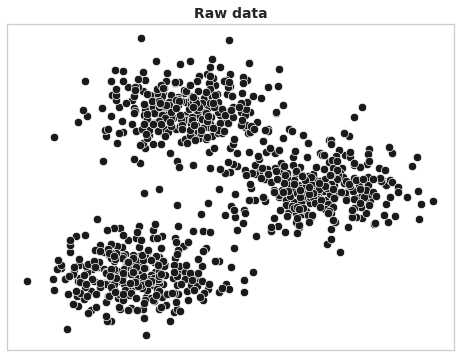

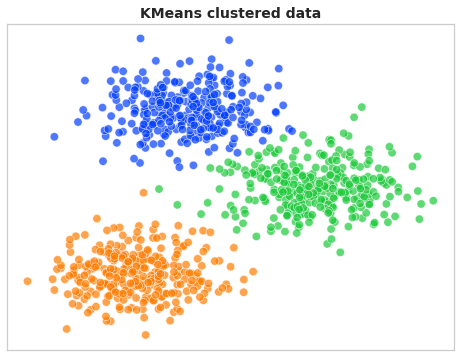

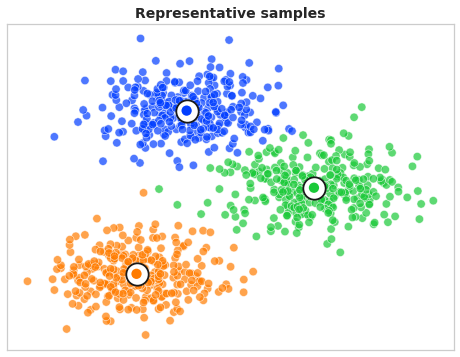

In [ ]:
from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse

# Sample data
n_samples = 900
centers = 3

X, y_true = make_blobs(n_samples = n_samples, centers = centers, cluster_std = 2, random_state = 12345)
X = X[:, ::-1]

sample_kmeans = KMeans(n_clusters = centers, random_state = 123)
samples_clusters = sample_kmeans.fit(X)
sample_labels = samples_clusters.labels_
sample_centers = samples_clusters.cluster_centers_
sample_centers = pd.DataFrame(sample_centers)
sample_centers['labels'] = [1, 2, 3]
X_df = pd.DataFrame(X)
X_df['labels'] = sample_labels

plt.figure(figsize = (8, 6))
sns.scatterplot(x = 0, y = 1, data = X_df, color = "k", s = 70, alpha = 1)
plt.title("Raw data", fontsize = 14, fontweight = "bold")
plt.xticks([])
plt.yticks([])
plt.ylabel("")
plt.xlabel("")

plt.figure(figsize = (8, 6))
sns.scatterplot(x = 0, y = 1, data = X_df, hue = 'labels', s = 70, alpha = 0.7, palette = "bright", legend = False)
plt.title("KMeans clustered data", fontsize = 14, fontweight = "bold")
plt.xticks([])
plt.yticks([])
plt.ylabel("")
plt.xlabel("")

plt.figure(figsize = (8, 6))
sns.scatterplot(x = 0, y = 1, data = X_df, hue = 'labels', s = 70, alpha = 0.7, palette = "bright", legend = False)
sns.scatterplot(x = sample_centers[0], y = sample_centers[1], marker = "o", s = 500, color = "white", edgecolor = "k")
sns.scatterplot(x = 0, y = 1, data = sample_centers, hue = 'labels', marker = ".", s = 600, palette = "bright", legend = False)
plt.title("Representative samples", fontsize = 14, fontweight = "bold")
plt.xticks([])
plt.yticks([])
plt.ylabel("")
plt.xlabel("")
plt.show()

In [ ]:
# K-Means++ clustering
k = 300

kmeans = KMeans(n_clusters = k, random_state = 123)
X_clustered = kmeans.fit_transform(X_train_lsa)

# Representative tweets
representative_ids = np.argmin(X_clustered, axis = 0)
X_representative = X_train[representative_ids]
X_representative_tfidf = X_train_tfidf[representative_ids]

# Representative tweets' labels
y_representative = raw_data.loc[X_representative.index, 'target']

print(X_representative_tfidf.shape)
print(y_representative.shape)

(300, 13053)
(300,)


In [ ]:
# Number of unique representative tweets
len(np.unique(representative_ids))

299

In [ ]:
# Number of disaster tweets
sum(y_representative)

129

### 4.1. Performance on representative samples

In [ ]:
# Evaluating cluster centered representative tweets
evaluate(X_representative_tfidf, y_representative, X_val_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.587     0.959     0.728       814
           1      0.828     0.224     0.353       709

    accuracy                          0.617      1523
   macro avg      0.707     0.592     0.541      1523
weighted avg      0.699     0.617     0.554      1523
 

K-Nearest Neighbors vote classification report: 
               precision    recall  f1-score   support

           0      0.693     0.744     0.718       814
           1      0.679     0.621     0.648       709

    accuracy                          0.687      1523
   macro avg      0.686     0.683     0.683      1523
weighted avg      0.686     0.687     0.685      1523



(0.35294117647058826,
 0.6172028890347997,
 0.6484893146647016,
 0.6868023637557452)

### 4.2. Performance on partially propagated samples
> Reference documentation:
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, September 2019 - by Aurélien Géron

In [ ]:
# Propagating cluster labels
y_propagated = np.empty(len(X_train), dtype = np.int32)
for i in range(k):
    y_propagated[kmeans.labels_ == i] = list(y_representative)[i]

# Approximation percentile
percentile_closest = 3

X_cluster_dist = X_clustered[np.arange(len(X_train)), kmeans.labels_]

# Propagating based on approximation percentile
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_partially_propagated = X_train_tfidf[partially_propagated]
y_partially_propagated = y_propagated[partially_propagated]

print(f'Propagated training set shape: {X_partially_propagated.shape}')
print(f'Propagation accuracy: {np.mean(y_partially_propagated == y_train[partially_propagated]) * 100:.2f}%')

Propagated training set shape: (680, 13053)
Propagation accuracy: 89.85%


In [ ]:
# Evaluating partially propagated set
evaluate(X_partially_propagated, y_partially_propagated, X_val_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.691     0.833     0.755       814
           1      0.749     0.573     0.649       709

    accuracy                          0.712      1523
   macro avg      0.720     0.703     0.702      1523
weighted avg      0.718     0.712     0.706      1523
 

K-Nearest Neighbors vote classification report: 
               precision    recall  f1-score   support

           0      0.695     0.724     0.709       814
           1      0.667     0.635     0.650       709

    accuracy                          0.682      1523
   macro avg      0.681     0.679     0.680      1523
weighted avg      0.682     0.682     0.682      1523



(0.6490807354116707,
 0.7117531188443861,
 0.6502890173410405,
 0.6822061720288903)

## 5.) Iterative clustering approach with varying cluster numbers

### 5.1. Silhouette width for N random initializations

In [ ]:
clusters = {}
clusters['k'] = []

clusters['init'] = []
clusters['distances'] = []
clusters['labels'] = []
clusters['silhouette_width'] = []

cluster_sizes = [20, 30, 40, 50, 75, 100, 125, 150, 175, 200,
                 250, 300, 400, 500, 750, 1000, 1500, 2000]

# Setting NumPy random seed for reproducibility
np.random.seed(123)
for k in cluster_sizes:

    # Fitting 10 random initialization of k-means clustering
    tic = time()
    silhouette_list = []
    
    for i in range(10):
        clusters['k'].append(k)
        clusters['init'].append(i + 1)
        minibatch_kmeans
        kmeans = KMeans(n_clusters = k, n_init = 3)
        distances = kmeans.fit_transform(X_train_lsa)
        clusters['distances'].append(distances)
        labels = kmeans.labels_
        clusters['labels'].append(labels)

        silhouette_width = silhouette_score(X_train_lsa, labels)
        clusters['silhouette_width'].append(silhouette_width)
        silhouette_list.append(silhouette_width)
    
    silhouette_avg = np.mean(silhouette_list)
    toc = time()
    elapsed = toc - tic

    print(f"For K = {k}",
          f"the average silhouette width is: {silhouette_avg:.4f}.",
          f"Elapsed time {elapsed:.3f}s")

For K = 20 the average silhouette width is: 0.0231. Elapsed time 19.840s
For K = 30 the average silhouette width is: 0.0311. Elapsed time 21.973s
For K = 40 the average silhouette width is: 0.0403. Elapsed time 23.917s
For K = 50 the average silhouette width is: 0.0486. Elapsed time 26.262s
For K = 75 the average silhouette width is: 0.0670. Elapsed time 30.038s
For K = 100 the average silhouette width is: 0.0816. Elapsed time 39.082s
For K = 125 the average silhouette width is: 0.0940. Elapsed time 42.099s
For K = 150 the average silhouette width is: 0.1057. Elapsed time 47.611s
For K = 175 the average silhouette width is: 0.1158. Elapsed time 50.477s
For K = 200 the average silhouette width is: 0.1242. Elapsed time 53.305s
For K = 250 the average silhouette width is: 0.1375. Elapsed time 59.642s
For K = 300 the average silhouette width is: 0.1461. Elapsed time 63.621s
For K = 400 the average silhouette width is: 0.1585. Elapsed time 75.514s
For K = 500 the average silhouette width is

### 5.2. Performance on varying cluster numbers

In [ ]:
# Evaluation routine and comparison with naive labeling method
eval = {}
eval['k'] = []
eval['init'] = []
eval['classifier'] = []
eval['method'] = []
eval['representatives'] = []
eval['f1_score'] = []
eval['accuracy'] = []

for k, init, distance in zip(clusters['k'], clusters['init'], clusters['distances']):
    eval['k'].append(k)
    eval['init'].append(init)

    representatives = np.argmin(distance, axis = 0)
    eval['representatives'].append(representatives)
    X_representative_tfidf = X_train_tfidf[representatives]
    y_representative = raw_data.loc[representatives, 'target']

    # Representative Labeling - Accuracy and F1 score
    log_r_f1, log_r_acc, knn_c_f1, knn_c_acc = evaluate(X_representative_tfidf,
                                                        y_representative,
                                                        X_val_tfidf,
                                                        classif_report = False)
    
    eval['classifier'].append('Logistic Regression')
    eval['method'].append('Representative Labeling')
    eval['f1_score'].append(log_r_f1)
    eval['accuracy'].append(log_r_acc)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('KNN Classifier')
    eval['method'].append('Representative Labeling')
    eval['f1_score'].append(knn_c_f1)
    eval['accuracy'].append(knn_c_acc)

    # Naive Labeling - Accuracy and F1 score
    log_r_f1_n, log_r_acc_n, knn_c_f1_n, knn_c_acc_n = evaluate(X_train_tfidf[:k],
                                                                y_train[:k],
                                                                X_val_tfidf,
                                                                classif_report = False)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('Logistic Regression')
    eval['method'].append('Naive Labeling')
    eval['f1_score'].append(log_r_f1_n)
    eval['accuracy'].append(log_r_acc_n)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('KNN Classifier')
    eval['method'].append('Naive Labeling')
    eval['f1_score'].append(knn_c_f1_n)
    eval['accuracy'].append(knn_c_acc_n)

In [ ]:
# clusters and eval as dataframes
eval_df = pd.DataFrame(eval)
clusters_df = pd.DataFrame(clusters)

In [ ]:
eval_df.head()

,k,init,classifier,method,representatives,f1_score,accuracy
0,20,1,Logistic Regression,Representative Labeling,"[5280, 811, 5232, 4440, 5876, 1561, 3905, 4647...",0.000000,0.534471
1,20,1,KNN Classifier,Representative Labeling,"[5280, 811, 5232, 4440, 5876, 1561, 3905, 4647...",0.340934,0.601445
2,20,1,Logistic Regression,Naive Labeling,"[5280, 811, 5232, 4440, 5876, 1561, 3905, 4647...",0.635305,0.465529
3,20,1,KNN Classifier,Naive Labeling,"[5280, 811, 5232, 4440, 5876, 1561, 3905, 4647...",0.615308,0.491793
4,20,2,Logistic Regression,Representative Labeling,"[1153, 4103, 5835, 811, 2184, 1199, 3059, 3241...",0.013966,0.536441


In [ ]:
clusters_df.head()

,k,init,distances,labels,silhouette_width
0,20,1,"[[1.2148020209709562, 1.0292606820957029, 0.97...","[2, 19, 19, 19, 18, 19, 19, 14, 16, 14, 8, 8, ...",0.022036
1,20,2,"[[1.0896813049311624, 1.05049584471339, 1.0452...","[10, 16, 10, 7, 6, 16, 7, 16, 18, 8, 6, 6, 6, ...",0.023538
2,20,3,"[[0.9905983567834823, 1.0219376591016223, 1.37...","[8, 5, 8, 6, 12, 6, 11, 5, 15, 15, 0, 0, 0, 17...",0.022938
3,20,4,"[[1.0380223178488917, 1.0855865441634387, 1.00...","[19, 11, 2, 2, 13, 11, 4, 11, 5, 9, 13, 13, 13...",0.025398
4,20,5,"[[1.1167391277002994, 1.1150223050468202, 0.99...","[11, 2, 3, 3, 11, 19, 3, 15, 7, 19, 2, 2, 2, 3...",0.022460


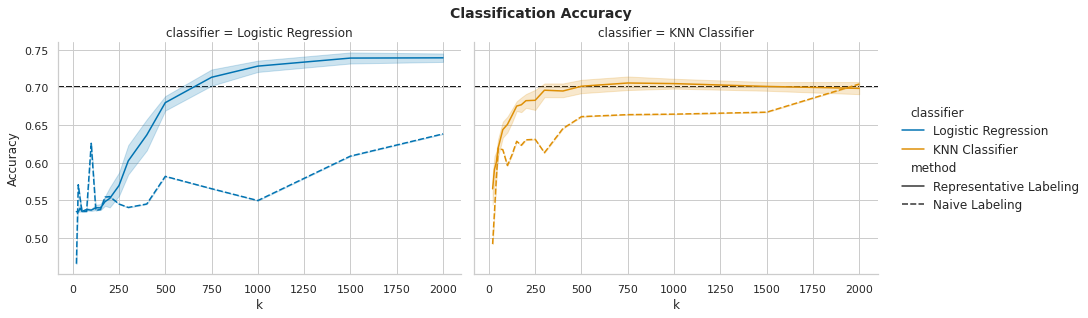

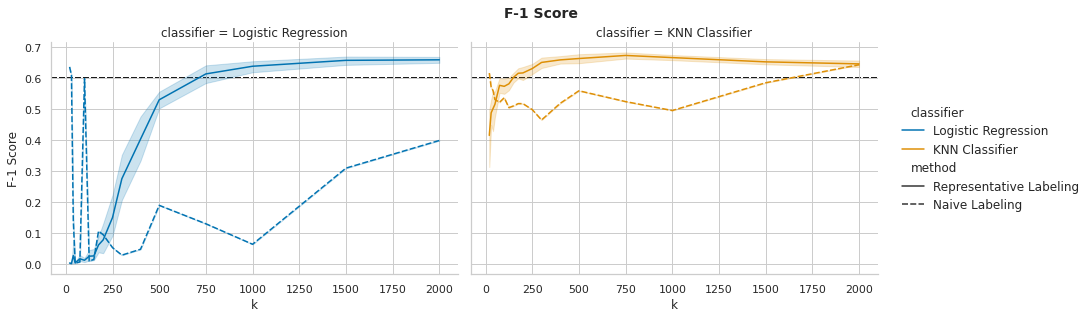

In [ ]:
rp = sns.relplot(data = eval_df, x = 'k', y = 'accuracy',
                 col = 'classifier', hue = 'classifier', style = "method",
                 kind = 'line', height = 4.5, aspect = 1.4)
rp.map(plt.axhline, y = 0.7, color = "k", dashes = (3, 1), linewidth = 2, zorder = 0)
rp.set_ylabels("Accuracy")
rp.fig.subplots_adjust(top = 0.87)
rp.fig.suptitle('Classification Accuracy', size = 14, fontweight = 'bold')

rp = sns.relplot(data = eval_df, x = 'k', y = 'f1_score',
                 col = 'classifier', hue = 'classifier', style = "method",
                 kind = 'line', height = 4.5, aspect = 1.4)
rp.map(plt.axhline, y = 0.6, color = "k", dashes = (3, 1), linewidth = 2, zorder = 0)
rp.set_ylabels("F-1 Score")
rp.fig.subplots_adjust(top = 0.87)
rp.fig.suptitle('F-1 Score', size = 14, fontweight = 'bold')
plt.show()

### 5.3. KNN Classifier vs. Logistic Regression

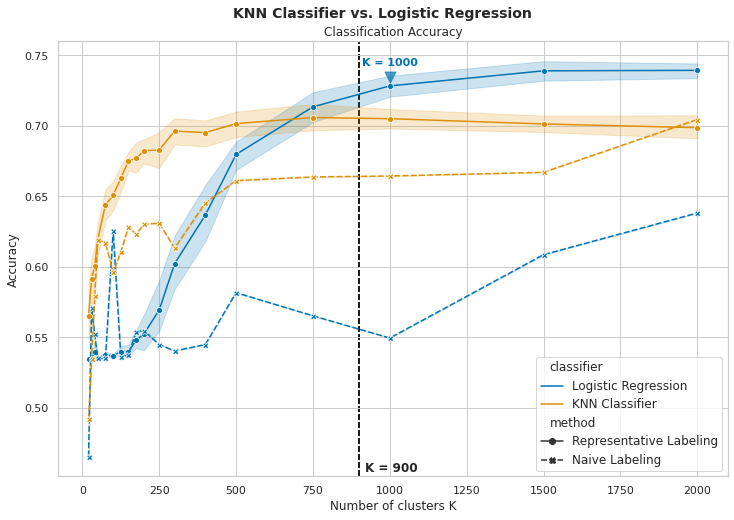

In [ ]:
# KNN vs. Logistic Regression
# Accuracy
plt.figure(figsize = (12, 8))
sns.lineplot(x = "k", y = "accuracy", hue = "classifier", style = "method",
             data = eval, markers = True)
# Horizontal line at K = 900
plt.axvline(x = 900, color = "k", dashes = (3, 1), linewidth = 2, zorder = 0)
plt.text(920, 0.455, "K = 900", size = 12, fontweight = "bold")
# Anotation at K = 1000
plt.scatter(1000, 0.735, marker = "v", c = "C0", alpha = 0.7, s = 120, zorder = 3)
plt.text(1000, 0.743, "K = 1000", size = 11, fontweight = "bold", c = "C0", horizontalalignment = "center")
plt.suptitle("KNN Classifier vs. Logistic Regression", size = 14, fontweight = 'bold', y = 0.94)
plt.title("Classification Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of clusters K")
plt.show()

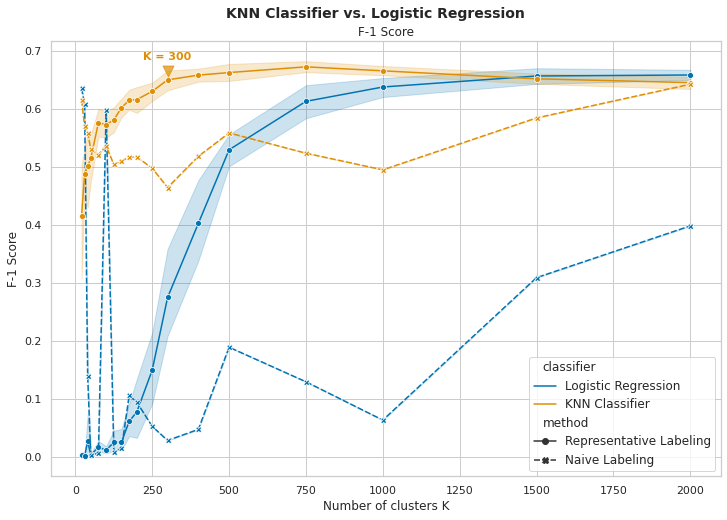

In [ ]:
# F-1 Score
plt.figure(figsize = (12, 8))
sns.lineplot(x = "k", y = "f1_score", hue = "classifier", style = "method",
             data = eval, markers = True)
# Anotation at K = 300
plt.scatter(300, 0.665, marker = "v", c = "C1", alpha = 0.7, s = 120, zorder = 3)
plt.text(300, 0.685, "K = 300", size = 11, fontweight = "bold", c = "C1", horizontalalignment = "center")
plt.suptitle("KNN Classifier vs. Logistic Regression", size = 14, fontweight = 'bold', y = 0.94)
plt.title("F-1 Score")
plt.ylabel("F-1 Score")
plt.xlabel("Number of clusters K")
plt.show()

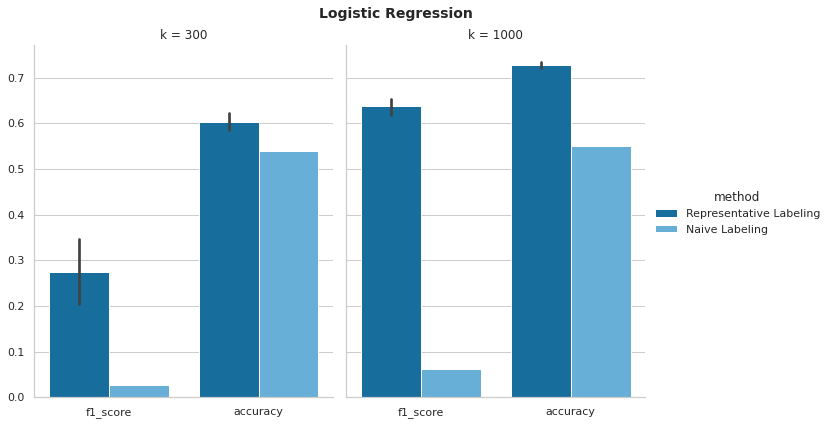

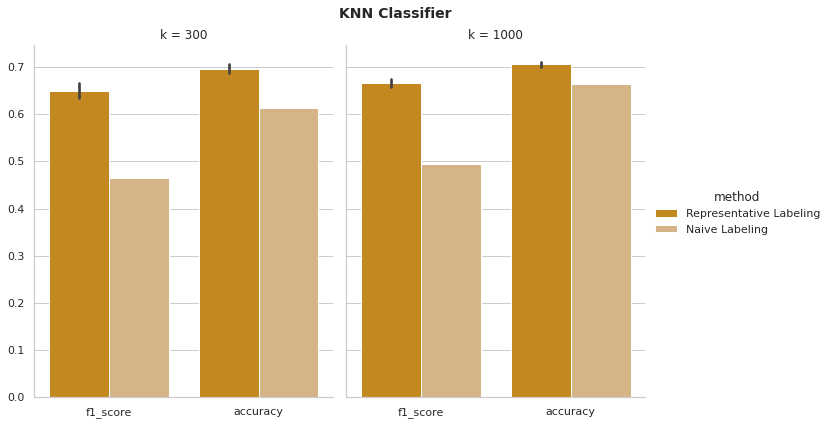

In [ ]:
logr_eval_subset = eval_df[(eval_df["classifier"] == "Logistic Regression") & ((eval_df["k"] == 300) | (eval_df["k"] == 1000))]
knn_eval_subset = eval_df[(eval_df["classifier"] == "KNN Classifier") & ((eval_df["k"] == 300) | (eval_df["k"] == 1000))]

logr_eval_subset = pd.melt(logr_eval_subset,
                          id_vars = ["k", "init", "classifier", "method", "representatives"],
                          value_vars = ["f1_score", "accuracy"],
                          var_name = "metric", value_name = "measurement")

knn_eval_subset = pd.melt(knn_eval_subset,
                            id_vars = ["k", "init", "classifier", "method", "representatives"],
                            value_vars = ["f1_score", "accuracy"],
                            var_name = "metric", value_name = "measurement")

g1 = sns.catplot(x = "metric", y = "measurement",
                 hue = "method", col = "k",
                 data = logr_eval_subset, kind = "bar",
                 height = 6, aspect = 0.8, palette = ("C0", "C9"))
g1.set_axis_labels("", "")
plt.suptitle("Logistic Regression", size = 14, fontweight = 'bold', y = 1.02)

g2 = sns.catplot(x = "metric", y = "measurement",
                 hue = "method", col = "k",
                 data = knn_eval_subset, kind = "bar",
                 height = 6, aspect = 0.8, palette = ("C1", "#e2b77b"))
g2.set_axis_labels("", "")
plt.suptitle("KNN Classifier", size = 14, fontweight = 'bold', y = 1.02)
plt.show()

## 6.) Clustering visualizations

### 6.1. LSA Biplots

In [ ]:
# Visualizing cluster characteristics
# Defining cluster biplot function
def clusterBiplot(k = None, init = "best", components = (1, 2), show_cluster_num = False):
    try:
        list(clusters_df.loc[clusters_df["k"] == k, "init"])[0]
    except:
        print(f"Invalid k. Please select a cluster size present in the list: {cluster_sizes}")
    else:
        # Retrieving best initialization for k
        if init == "best":
            k_max_sw = clusters_df.loc[clusters_df["k"] == k, "silhouette_width"].max()
            k_best_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["silhouette_width"] == k_max_sw)]
            k_init = int(k_best_init['init'])
            k_labels = list(k_best_init['labels'])[0]
            k_distances = list(k_best_init['distances'])[0]
        else:
            k_init = init
            k_selected_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["init"] == k_init)]
            k_labels = list(k_selected_init['labels'])[0]
            k_distances = list(k_selected_init['distances'])[0]

        # Representative coordinates
        k_representatives = np.argmin(k_distances, axis = 0)
        rep_coordinates = []
        for rep in k_representatives:
            rep_coord = X_train_lsa[rep, ]
            rep_coordinates.append(rep_coord)
        rep_coordinates = pd.DataFrame(rep_coordinates)
        
        # Plotting
        comp1 = components[0] -1 # Components starts at indexing = 0
        comp2 = components[1] -1 # Components starts at indexing = 0

        colors = cm.nipy_spectral(k_labels.astype(float) / k)
        plt.figure(figsize = (12, 8))
        plt.scatter(X_train_lsa[:, comp1], X_train_lsa[:, comp2],
                    marker = ".", s = 50, lw = 0, alpha = 0.7, c = colors, edgecolor = "k")

        # Plotting clusters' representative observations
        if show_cluster_num:
            plt.scatter(rep_coordinates[comp1], rep_coordinates[comp2],
                        marker = "o", c = "white", alpha = 1, s = 200, edgecolor = "k")
            for i, c in enumerate(rep_coordinates.values):
                color = cm.nipy_spectral(float(i) / k)
                plt.scatter(c[comp1], c[comp2], marker = "$%d$" % (i +1), alpha = 1, s = 100, color = color)
        else:
            plt.scatter(rep_coordinates[comp1], rep_coordinates[comp2],
                        marker = "o", c = "white", alpha = 1, s = 150, edgecolor = "k")
            for i, c in enumerate(rep_coordinates.values):
                color = cm.nipy_spectral(float(i) / k)
                plt.scatter(c[comp1], c[comp2], marker = ".", alpha = 1, s = 100, color = color)
        plt.suptitle(f"Clustering biplot of LSA components {(comp1 +1, comp2 +1)}",
                     size = 14, fontweight = 'bold', y = 0.94)
        plt.title(f"k = {k}, initialization {k_init}")
        plt.xlabel("Component " + str(comp1 +1))
        plt.ylabel("Component " + str(comp2 +1))
        plt.show()

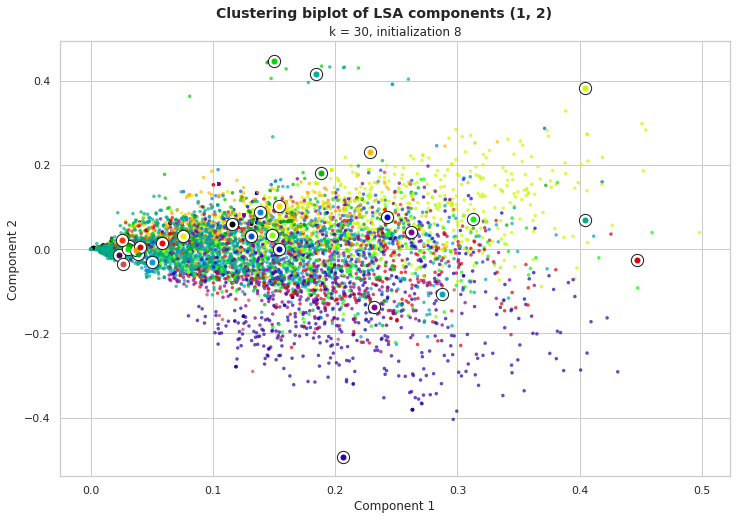

In [ ]:
clusterBiplot(k = 30, components = (1, 2))

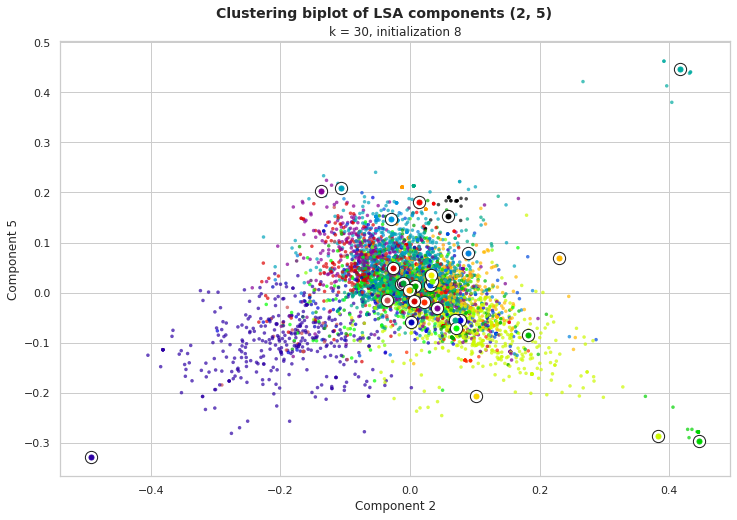

In [ ]:
clusterBiplot(k = 30, components = (2, 5))

In [ ]:
# Finding best dimensions to visualize the representative sample
def findComponents(k = None, init = "best", cluster = None):
    try:
        list(clusters_df.loc[clusters_df["k"] == k, "init"])[0]
    except:
        print(f"Invalid k. Please select a cluster size present in the list: {cluster_sizes}")
    else:
        # Retrieving best initialization for k
        if init == "best":
            k_sw = clusters_df.loc[clusters_df["k"] == k, "silhouette_width"].max()
            k_best_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["silhouette_width"] == k_sw)]
            k_init = int(k_best_init['init'])
            k_labels = list(k_best_init['labels'])[0]
            k_representatives = np.argmin(list(k_best_init['distances'])[0], axis = 0)
        else:
            k_init = init
            k_selected_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["init"] == k_init)]
            k_sw = float(k_selected_init['silhouette_width'])
            k_labels = list(k_selected_init['labels'])[0]
            k_representatives = np.argmin(list(k_selected_init['distances'])[0], axis = 0)

        # run = clusters_df.loc[(clusters_df['k'] == k) & (clusters_df['init'] == init)]
        temp_df = pd.DataFrame(X_train_lsa)
        temp_df['labels'] = k_labels
        # temp_df['labels'] = pd.Series(run['labels'].values[0])
        temp_rep = k_representatives
        target_rep = temp_rep[(cluster -1)]
        target_rep_df = temp_df[temp_df.index == target_rep]
        best_components = target_rep_df.abs().max().sort_values(ascending = False)[:3].index

        print(f"Best components for representative sample: {(best_components[1] +1, best_components[2] +1)}")
    
findComponents(k = 50, cluster = 15)

Best components for representative sample: (35, 37)


### 6.2. Silhouette Width and Cluster Sizes

In [ ]:
def clusterSilhouettes(k = None, init = "best", anotate = True):
    try:
        list(clusters_df.loc[clusters_df["k"] == k, "init"])[0]
    except:
        print(f"Invalid k. Please select a cluster size present in the list: {cluster_sizes}")
    else:
        # Retrieving best initialization for k
        if init == "best":
            k_sw = clusters_df.loc[clusters_df["k"] == k, "silhouette_width"].max()
            k_best_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["silhouette_width"] == k_sw)]
            k_init = int(k_best_init['init'])
            k_labels = list(k_best_init['labels'])[0]
        else:
            k_init = init
            k_selected_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["init"] == k_init)]
            k_sw = float(k_selected_init['silhouette_width'])
            k_labels = list(k_selected_init['labels'])[0]

        # Sample silhouette values
        k_silhouette_values = silhouette_samples(X_train_lsa, k_labels)
        
        y_lower = 10
        sample_sw_list = []
        plt.figure(figsize = (12, 8))
        for i in range(k):
            ith_cluster_silhouette_values = k_silhouette_values[k_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            highest_sw = ith_cluster_silhouette_values[-1]
            sample_sw_list.append(highest_sw)

            color = cm.nipy_spectral(float(i) / k)
            plt.fill_between(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                             facecolor = color, edgecolor = color, alpha = 0.7)
            if anotate:
                plt.text(y_lower + 0.5 * size_cluster_i,
                        highest_sw + 0.02,
                        str(size_cluster_i),
                        horizontalalignment = "center")
                plt.text(y_lower + 0.5 * size_cluster_i,
                        highest_sw + 0.06,
                        i +1, color = color, fontweight = "bold",
                        horizontalalignment = "center")
            y_lower = y_upper + 10
            
        highest_sw = max(sample_sw_list)
        plt.ylim(top = highest_sw + 0.1)
        plt.suptitle("Silhouette Widths and Cluster Sizes", size = 14, fontweight = 'bold', y = 0.94)
        plt.title(f"k = {k}, initialization {k_init}. Average Silhouette Width = {k_sw:.3f}")
        plt.xticks([])
        plt.ylabel("Silhouette width")
        plt.show()

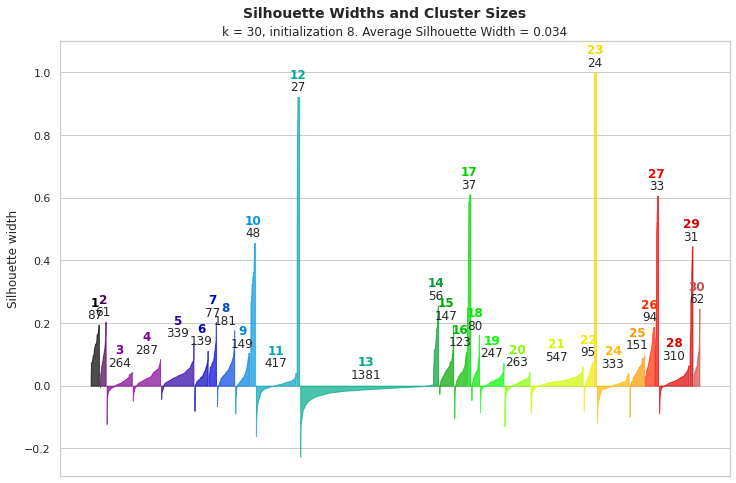

In [ ]:
clusterSilhouettes(k = 30, anotate = True)

### 6.3. Tweets' text in each cluster

In [ ]:
def clusterTweets(k = None, cluster = 1, init = "best", sorted = True):
    try:
        list(clusters_df.loc[clusters_df["k"] == k, "init"])[0]
    except:
        print(f"Invalid k. Please select a cluster size present in the list: {cluster_sizes}")
    else:
        # Retrieving best initialization for k
        if init == "best":
            k_sw = clusters_df.loc[clusters_df["k"] == k, "silhouette_width"].max()
            k_best_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["silhouette_width"] == k_sw)]
            k_init = int(k_best_init['init'])
            k_labels = list(k_best_init['labels'])[0]
            k_distances = list(k_best_init['distances'])[0]
        else:
            k_init = init
            k_selected_init = clusters_df[(clusters_df["k"] == k) & (clusters_df["init"] == k_init)]
            k_sw = float(k_selected_init['silhouette_width'])
            k_labels = list(k_selected_init['labels'])[0]
            k_distances = list(k_selected_init['distances'])[0]
        
        # Creating labeled dataframe with tweets, cluster labels and distances
        labeled_df = pd.DataFrame((k_labels +1), columns = ['cluster'])
        labeled_df['tweet'] = X_train
        labeled_df['ground_truth'] = y_train
        labeled_df['distance'] = k_distances[:, (cluster -1)]

        # Sub-setting observations present in the selected cluster
        in_cluster_df = labeled_df[labeled_df['cluster'] == cluster]

        print(f"Retrieved results for initialization {k_init}")
        if sorted:
            return in_cluster_df.sort_values('distance', ascending = True)
            # return k_distances
        else:
            return in_cluster_df

In [ ]:
clusterTweets(k = 30, cluster = 1)

Retrieved results for initialization 8


,cluster,tweet,ground_truth,distance
578,1,FedEx will no longer transport bioterror patho...,0,0.787528
589,1,alisonannyoung: EXCLUSIVE: FedEx no longer to ...,0,0.789814
604,1,#FedEx no longer to transport bioterror germs ...,1,0.802045
606,1,FedEx no longer to transport bioterror germs i...,0,0.802045
592,1,FedEx no longer to transport bioterror germs i...,1,0.802045
...,...,...,...,...
4216,1,DLH issues Hazardous Weather Outlook (HWO),1,1.002347
4236,1,MEG issues Hazardous Weather Outlook (HWO),1,1.002347
4246,1,DLH issues Hazardous Weather Outlook (HWO) #WX,1,1.002431
4230,1,MEG issues Hazardous Weather Outlook (HWO) #WX,1,1.002431


## 7.) Exploratory Analysis

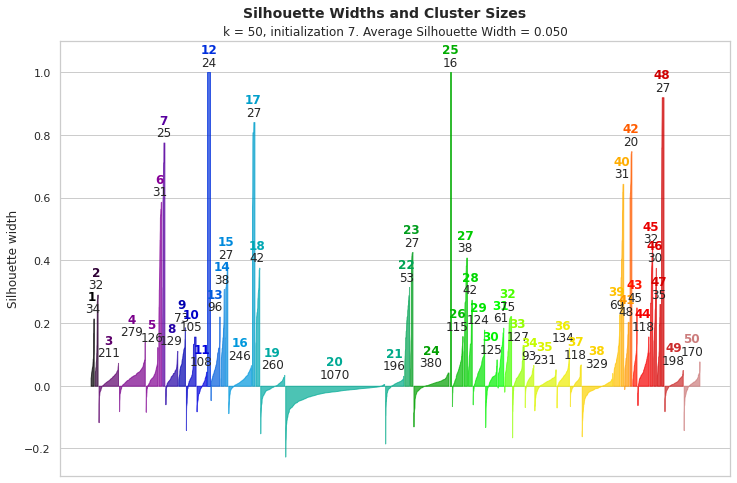

In [ ]:
clusterSilhouettes(k = 50, anotate = True)

In [ ]:
investigate_df = clusterTweets(k = 50, cluster = 15).head(10)
for y, tweet in zip(investigate_df['ground_truth'], investigate_df['tweet']):
    print(y, tweet)

Retrieved results for initialization 7
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 #ModiMinistry Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
1 #TeamFollowBack Madhya Pradesh Train Derailment: Village Youth Saved Many Lives #FollowBack
1 #news Madhya Pradesh Train Derailment: Village Youth Saved Many Lives #til_now #NDTV
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...
1 Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...


In [ ]:
findComponents(k = 50, init = 7, cluster = 15)

Best components for representative sample: (35, 37)


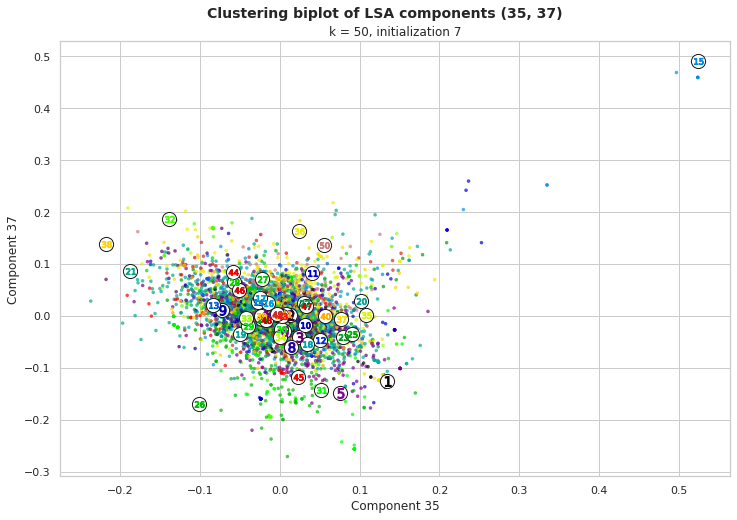

In [ ]:
clusterBiplot(k = 50, components = (35, 37), show_cluster_num = True)

In [ ]:
investigate_df = clusterTweets(k = 50, cluster = 48).head(10)
for y, tweet in zip(investigate_df['ground_truth'], investigate_df['tweet']):
    print(y, tweet)

Retrieved results for initialization 7
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea...
1 Families to sue over Legionnair

In [ ]:
findComponents(k = 50, init = 7, cluster = 48)

Best components for representative sample: (4, 5)


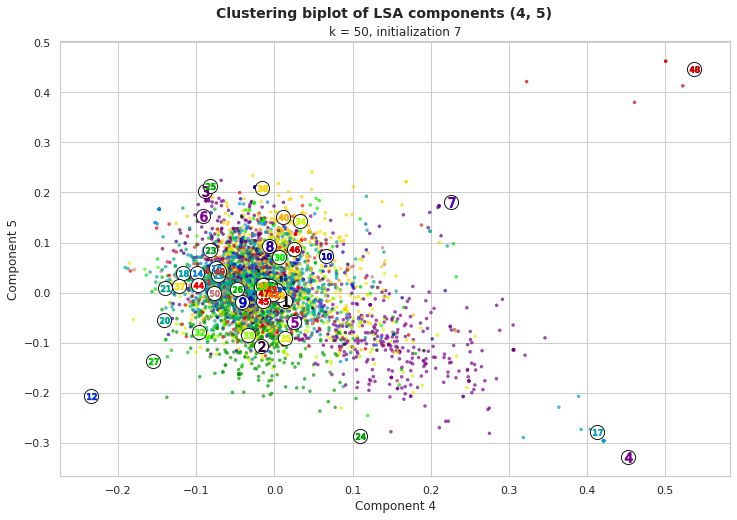

In [ ]:
clusterBiplot(k = 50, components = (4, 5), show_cluster_num = True)

In [ ]:
investigate_df = clusterTweets(k = 50, cluster = 12).head(10)
for y, tweet in zip(investigate_df['ground_truth'], investigate_df['tweet']):
    print(y, tweet)

Retrieved results for initialization 7
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
1 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute


In [ ]:
findComponents(k = 50, init = 7, cluster = 12)

Best components for representative sample: (3, 7)


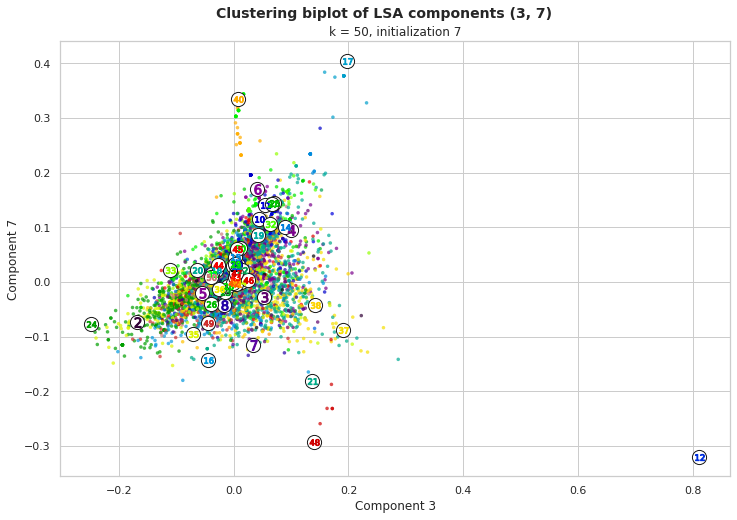

In [ ]:
clusterBiplot(k = 50, components = (3, 7), show_cluster_num = True)

In [ ]:
investigate_df = clusterTweets(k = 50, cluster = 18).head(10)
for y, tweet in zip(investigate_df['ground_truth'], investigate_df['tweet']):
    print(y, tweet)

Retrieved results for initialization 7
1 Aircraft debris found on island is from MH370 Malaysia confirms
1 Malaysia confirms Reunion Island debris is from MH370
1 MH370: Reunion debris is from missing Malaysia flight
1 #aerospace #exec Plane debris is from missing MH370 - Part of the aircraft wing found on Reunion Island is from th...
1 #?? #???? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...
1 #?? #???? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...
1 #?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...
1 #??? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...
1 #?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...
1 MH370: debris found on reunion island. ?? #sad #tragedy #innocent #crash #mh370


In [ ]:
findComponents(k = 50, init = 7, cluster = 18)

Best components for representative sample: (10, 13)


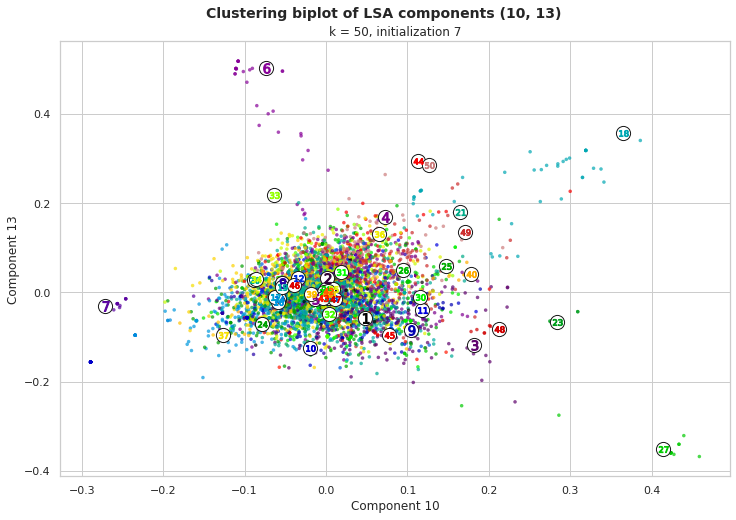

In [ ]:
clusterBiplot(k = 50, components = (10, 13), show_cluster_num = True)

In [ ]:
investigate_df = clusterTweets(k = 50, cluster = 43).head(10)
for y, tweet in zip(investigate_df['ground_truth'], investigate_df['tweet']):
    print(y, tweet)

Retrieved results for initialization 7
1 Flooding ????
1 Myanmar Flooding: Heavy monsoon rains during the month of July have caused flooding flash floods and landsli...
1 There some flash flooding in madison #valleywx
1 Flooding of tracks caused derailment sa #INSubcontinent
1 #Laos flooding -10 villages underwater World Vision responding
0 Tips to prevent basement leaks - Create control joints to eliminate random cracking. #homeimprovement #Flooding
1 Monsoon Flooding Kills Dozens In Myanmar Prompting Calls For Help -
0 No reported flooding po in the area. Ten-4. #mmda
1 Business at the Sponge Docks washed out by rain flooding:
0 LRT LOOK AT ALL MY TOM FEELS FLOODING BACK


In [ ]:
findComponents(k = 50, init = 7, cluster = 43)

Best components for representative sample: (193, 184)


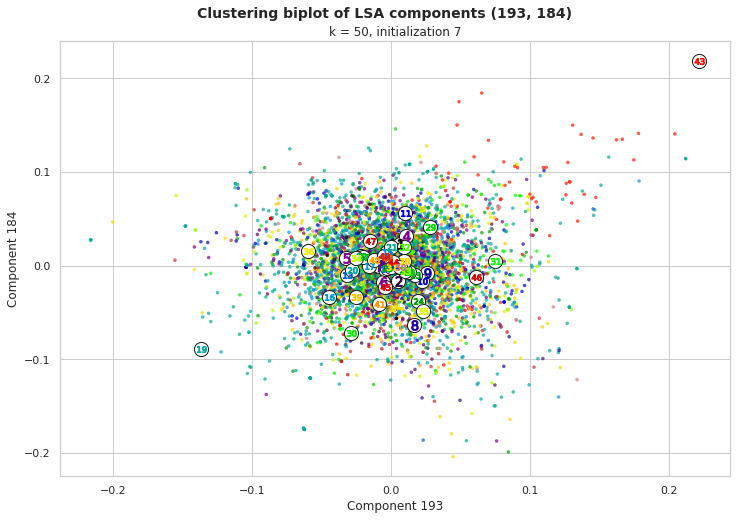

In [ ]:
clusterBiplot(k = 50, components = (193, 184), show_cluster_num = True)

## 8.) Extra comments
- Representative labeling might induce bias into your model if K is too low for the diversity present in the target dataset.
- Overfitting might occur earlier in your training and validation process when using representative labelled samples, since the concept sets aside hard-to-define, diffuse, and less representative samples.
- Some of the KMeans assumptions for an accurate clustering are not proved during this method due to the high dimensionality and number of clusters. Hence, problems of unequal variance and anisotropicity might result in inapropriate cluster centers (and therefore, on inapropriate representative tweets). Visualization of KMeans assumptions: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html